**ULMFiT model to Twitter US Airlines Sentiment**

In [ ]:
# importing libraries 
from fastai.text import * 

1. Data Wrangling

In [ ]:
# importing from csv 
dataset = pd.read_csv("Tweets.csv")
dataset.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


2. Data Exploration

In [ ]:
# total number of tweets per each airline
tweetsCount = dataset.groupby(["airline"])["tweet_id"].count()
tweetsCount

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: tweet_id, dtype: int64

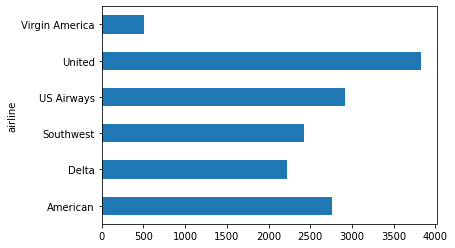

In [ ]:
# horizontal bar graph showcasing the total number of tweets per each airline
tweetsCount.plot.barh()

In [ ]:
# total number of tweets per each sentiment
sentimentCount = dataset.groupby(["airline_sentiment"])["tweet_id"].count()
sentimentCount

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: tweet_id, dtype: int64

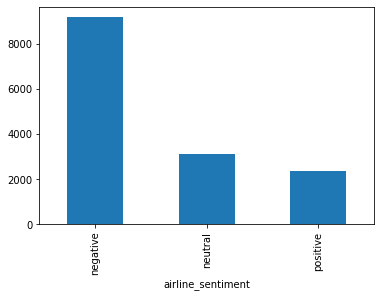

In [ ]:
# vertical bar graph showcasing the total number of tweets per each airline
sentimentCount.plot.bar()

In [ ]:
# total number of tweets per each airline of each sentiment
tweetTypeCount = dataset.groupby(["airline", "airline_sentiment"])["tweet_id"].count()
tweetTypeCount

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: tweet_id, dtype: int64

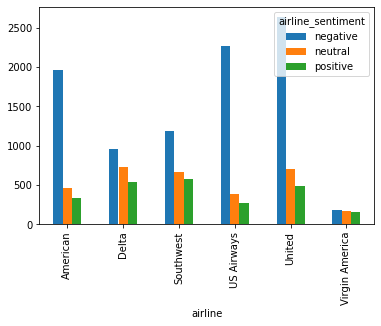

In [ ]:
# color coded bar graph showing the total number of tweets per each airline of each sentiment
tweetTypeCount.unstack().plot.bar()

3. Data Cleansing

In [ ]:
# subsetting tweet text and sentiment label for modeling
df = dataset[["airline_sentiment", "text"]]
df = df.rename(columns = {"airline_sentiment": "label"})
df.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
# helper functions to remove twitter handle name and unwanted characters from tweet text 
 
def removeHandleID(text):
  text = re.sub('@[^\s]+', '', text)
  return text

def removeExtraSpace(text):
  text = re.sub(' {2,}', '', text)
  return text

def removeHashTags(text):
  text = re.sub(r'([#])', r' \1 ', text)
  return text

In [ ]:
# cleaning the tweet texts 
df.text = df.text.apply(removeHandleID)
df.text = df.text.apply(removeExtraSpace)
df.text = df.text.apply(removeHashTags)
df.head()

,label,text
0,neutral,Whatsaid.
1,positive,plus you've added commercials to the experien...
2,neutral,I didn't today... Must mean I need to take an...
3,negative,"it's really aggressive to blast obnoxious ""en..."
4,negative,and it's a really big bad thing about it


In [ ]:
# splitting dataset into training and validation sets 
validDF = df.sample(frac = 0.2)
trainDF = df.drop(validDF.index)

4. Data Modeling

In [ ]:
# making data ready for modeling

path = ""
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = trainDF, 
                                  valid_df = validDF, 
                                  path = path)
# Classifier model data
data_clas = TextClasDataBunch.from_df(path = path, 
                                      train_df = trainDF, 
                                      valid_df = validDF, 
                                      vocab = data_lm.train_ds.vocab, 
                                      bs = 32)

In [ ]:
# saving the preprocessed vocabulary mappings
data_lm.save('data_lm_export.pkl')
data_clas.save('data_clas_export.pkl')

In [ ]:
# loading the language data model
data_lm = load_data(path, 'data_lm_export.pkl')
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [ ]:
# fine tuning language model 
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.814970,4.222124,0.238867,00:10


In [ ]:
# unfreezing the model in order to fine-tune it
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.097507,3.950714,0.271512,00:13


In [ ]:
# text completion prediction
tempText = learn.predict("missing baggage", n_words = 10)
tempText

'missing baggage my provide the most expensive . my bag was not'

In [ ]:
# saving model for transfer learning
learn.save_encoder('ft_enc')

In [ ]:
# loading ULMFit Model and building a classifier
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult = 0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (11712 items)
x: TextList
xxbos xxmaj xxunk .,xxbos plus you 've added commercials to the experience ... xxunk .,xxbos i did n't today ... xxmaj must mean i need to take another trip !,xxbos it 's really aggressive to blast obnoxious " entertainment " in your guests ' faces & & they have little recourse,xxbos and it 's a really big bad thing about it
y: CategoryList
neutral,positive,neutral,negative,negative
Path: .;

Valid: LabelList (2928 items)
x: TextList
xxbos help http : / / t.co / xxunk,xxbos i dunno my travel information .. like what ?,xxbos xxup xxunk - xxmaj denver to xxmaj austin ... xxmaj still on the ground ...,xxbos xxmaj your response has been incredible . xxmaj truly amazed at the steps you have taken to xxunk your customer relations . xxmaj big thank you 😄,xxbos duh on baggage claim 2 more hours and counting .. xxmaj flights xxunk & & 1898 http : / / t.co / xxunk
y: CategoryList
neutral,neutral,negative,positive,nega

In [ ]:
# sample batch of classified data
data_clas.show_batch()

text,target
xxbos xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos xxmaj in car gng to xxup dfw . xxmaj pulled over 1hr ago - very icy roads . xxmaj on - hold with xxup aa since 1hr . xxmaj ca n't reach xxunk for xxup xxunk . xxmaj wat 2 do ?,negative
"xxbos file loc : xxup xxunk . xxmaj bag at airport since last nite . xxmaj not "" scheduled "" to get xxup xxunk xxunk xxunk 8 ? xxup why ? u shld b ashamed . i 'm disgusted w / u",negative
"xxbos been a very long day in xxmaj philly ... xxunk flt to xxup ord xxmaj cancelled xxmaj flighted with xxup no notice , no message , no email . xxup not xxup nice xxup for xxup we xxup xxunk .",negative
"xxbos xxmaj it 's for me , i spoke with a rep on the phone who suggested i "" xxmaj voice a concern "" via "" xxmaj email us "" on your site . i did a few moments ago",neutral


In [ ]:
# learning rate tuning
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.711908,0.588641,0.756831,00:13


In [ ]:
# unfreezing the model in order to fine-tune it
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.605071,0.552391,0.768101,00:14


In [ ]:
# unfreezing the model in order to fine-tune it
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.594402,0.510120,0.795765,00:30


5. Results

In [ ]:
# calculating accuracy from classification interpretation
interpret = TextClassificationInterpretation.from_learner(learn)
accuracy = accuracy(interpret.preds, interpret.y_true)
print("Accuracy: {0:.3f}%".format(accuracy*100))

Accuracy: 79.577%


Text(0.5, 1.0, 'Confusion Matrix')

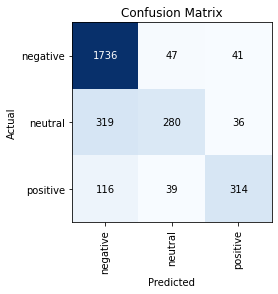

In [ ]:
# plotting a confusion matirx
interpret.plot_confusion_matrix()
plt.title("Confusion Matrix")

In [ ]:
# sample test 
tempText
learn.predict(tempText)

(Category tensor(0), tensor(0), tensor([9.9073e-01, 8.7126e-03, 5.5811e-04]))